In [968]:
!pip install requests

In [969]:
import requests

In [970]:
username = 'emma.c.j.schultz@gmail.com'
password = 'Possy0208!'


In [971]:
session = requests.Session()
response = session.post('https://posit.cloud/api/auth/login', json={'username': username, 'password': password})
response.raise_for_status()

In [1012]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd

# Function to remove seasonal mean and divide by seadonal standard deviation
def anomalize(dataseries, divide_by_std=True, reference_bounds = None, cycle_length=12, return_cycle=False):
    if reference_bounds is None:
        reference_bounds = (0, len(dataseries))

    anomaly = np.copy(dataseries)
    for t in range(cycle_length):
        if return_cycle:
            anomaly[t::cycle_length] = dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].mean(axis=0)
        else:
            anomaly[t::cycle_length] -= dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].mean(axis=0)
            if divide_by_std:
                anomaly[t::cycle_length] /= dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].std(axis=0)
    return anomaly


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

import tigramite
import tigramite.data_processing as pp
import tigramite.plotting as tp

from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr

from tigramite.models import LinearMediation, Models
from tigramite.causal_effects import CausalEffects

import os

import pkg_resources

In [998]:
def deTrend_deSeasonalize(data, show_plot = True):
    # step 1: seasonal component
    decomposition = seasonal_decompose(data, model='additive', period=12)
    data = data - decomposition.seasonal
    # step 2: Trend based on Gaussian kernel smoother
    smoothed = pp.smooth(np.copy(data), smooth_width=15 * 12, residuals=False)
    index = range(0, len(data))

    if show_plot == True:
        plt.plot(index, data)
        plt.plot(index,smoothed)
        plt.legend(['data', 'Smoothed trend'])
        plt.title("Deseasonalized data with smoothed trend")
        plt.show()

    else:
        result = data - smoothed
        return result

In [999]:
def deTrend(data):
    # Trend based on Gaussian kernel smoother
    smoothed = pp.smooth(np.copy(data), smooth_width=30 * 12, residuals=True)
    return smoothed


In [1124]:
# Function that makes El nino, La nina mask
# input data from correct years + 1 from the climate explorer
# set to False if we do NOT want to mask this value

def mask_maker(df_sstnino34):
    nino34list = df_sstnino34[:,1:].reshape(-1)

    nino34list = deTrend(nino34list[:-8])
    nino34list = np.append(nino34list, np.zeros(8))
    nino34list_by_year = nino34list.reshape(-1,12)

    # NINO MASK
    
    ninamask = np.ones(len(nino34list)).reshape(-1,12)
    ninomask = np.ones(len(nino34list)).reshape(-1,12)
    neutralmask = np.ones(len(nino34list)).reshape(-1,12)

    for i in range(len(nino34list_by_year)-1):
        if (nino34list_by_year[i,10] + nino34list_by_year[i,11] + nino34list_by_year[i+1,0])/3 > 0.5:
            ninomask[i,1:] = False
            ninomask[i+1,0] = False
    ninomask = ninomask[:len(ninomask),:].reshape(-1)
    ninomask = ninomask[:-8]
    
    for i in range(len(nino34list_by_year)-1):
        if (nino34list_by_year[i,10] + nino34list_by_year[i,11] + nino34list_by_year[i+1,0])/3 < -0.5:
            ninamask[i,1:] = False
            ninamask[i+1,0] = False
    ninamask = ninamask[:len(ninamask),:].reshape(-1)
    ninamask = ninamask[:-8]
    
    for i in range(len(nino34list_by_year)-1):
        if -0.5 < (nino34list_by_year[i,10] + nino34list_by_year[i,11] + nino34list_by_year[i+1,0])/3 < 0.5:
            neutralmask[i,1:] = False
            neutralmask[i+1,0] = False
    #neutralmask = neutralmask[:len(neutralmask)-1,:].reshape(-1)
    neutralmask = neutralmask[:len(neutralmask),:].reshape(-1)  
    neutralmask = neutralmask[:-8]
    
    return ninomask, ninamask, neutralmask

In [1125]:
os.chdir('/Users/hp/Documents/Econometrics; Climate Economics/Scriptie/Data') 

#to check tigramite version
print(pkg_resources.get_distribution("tigramite").version)

5.2.0.2


In [1126]:
# Pick time range
start_year = 1950
length = 12*(2023 - start_year)

reanalysis_data = np.vstack((
    np.loadtxt('iera5_slp_130-150E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
    np.loadtxt('iera5_t2m_-150--130E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
    np.loadtxt('iera5_t2m_-100--80E_-5-5N_n.dat.txt', skiprows=20)[:, 1:].reshape(-1)[:length],
                )).T
T, N = reanalysis_data.shape

reanalysis_data = reanalysis_data[:-8]

In [1127]:
# Simple way to define time axis
datatime = np.linspace(start_year, 2023-1./12., T)

# Variable names used throughout
var_names = ['WPAC', 'CPAC', 'EPAC']

df_reanalysis = pd.DataFrame(reanalysis_data, columns=var_names)


In [1128]:
dataframe_reanalysis = pp.DataFrame(np.copy(reanalysis_data), 
                         datatime = np.arange(len(reanalysis_data)), 
                         var_names=var_names)


print(dataframe_reanalysis)

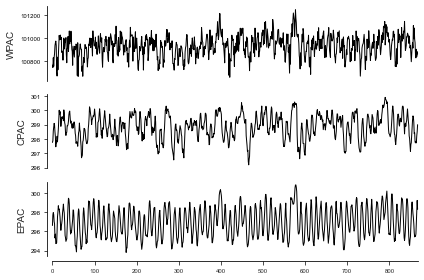

In [1129]:
tp.plot_timeseries(dataframe_reanalysis); plt.show()

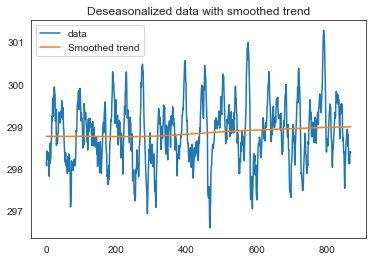

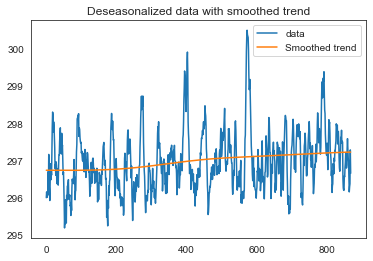

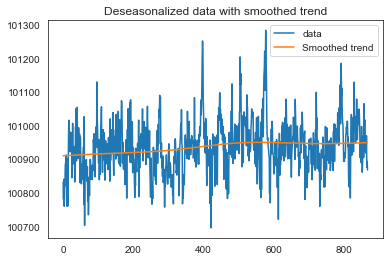

In [1130]:
deTrend_deSeasonalize(df_reanalysis['CPAC'], show_plot = True)
plt.show()
deTrend_deSeasonalize(df_reanalysis['EPAC'], show_plot = True)
plt.show()
deTrend_deSeasonalize(df_reanalysis['WPAC'], show_plot = True)
plt.show()

In [1131]:
cpac_detrend = deTrend_deSeasonalize(df_reanalysis['CPAC'], show_plot = False)
epac_detrend = deTrend_deSeasonalize(df_reanalysis['EPAC'], show_plot = False)
wpac_detrend = deTrend_deSeasonalize(df_reanalysis['WPAC'], show_plot = False)

In [1132]:
df_reanalysis_processed = pd.DataFrame({'WPAC': wpac_detrend, 'CPAC': cpac_detrend, 'EPAC': epac_detrend})

In [1133]:
dataframe = pp.DataFrame(df_reanalysis_processed.values, datatime = {0:np.arange(len(df_reanalysis_processed))}, var_names= var_names)

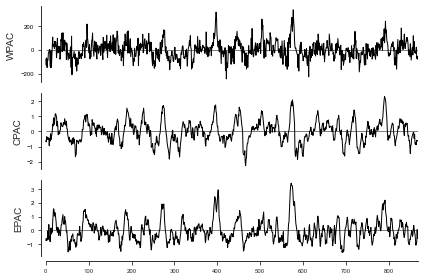

In [1134]:
# Diagnostic plots

# tigramite data inspection
# plot 1: timeseries
tp.plot_timeseries(dataframe, color='black', show_meanline=True)
plt.show()

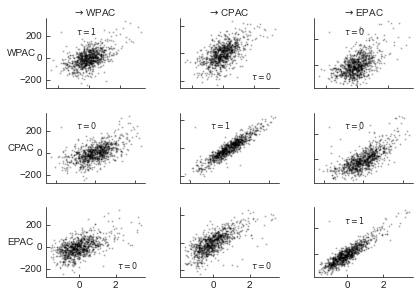

In [1135]:
# plot 2: scatterplots
matrix_lags = None
tp.plot_scatterplots(dataframe=dataframe)
plt.show()

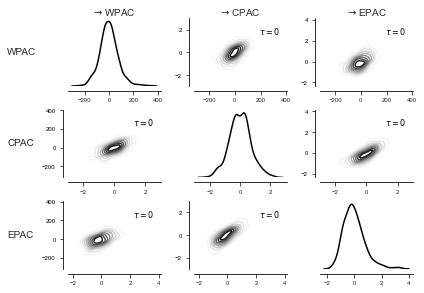

In [1136]:
# plot 3: marginal and joint densities
tp.plot_densityplots(dataframe=dataframe, add_densityplot_args={'matrix_lags':matrix_lags})
plt.show()

In [1137]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


In [1138]:
# Causal network 1: All observations
pcmci.verbosity = 1
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=1)
results_nomask = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable WPAC has 3 link(s):
        (CPAC -1): max_pval = 0.00000, min_val =  0.227
        (WPAC -2): max_pval = 0.00000, min_val =  0.170
        (WPAC -1): max_pval = 0.00000, min_val =  0.161

    Variable CPAC has 6 link(s):
        (CPAC -1): max_pval = 0.00000, min_val =  0.725
        (EPAC -1): max_pval = 0.00000, min_val =  0.174
        (CPAC -3): max_pval = 0.00030, min_val = -0.123
        (WPAC -3): max_pval = 0.00118, min_val = -0.110
        (WPAC -1): max_pval = 0.00444, min_val =  0.097
        (EPAC -2): max_pval = 0.04807, min_val = -0.068

    Variable EPAC has 3 link(s):
        (EPAC -1): max_pval = 0.00000, min_val =  0.720
        (EPAC -3): max_pval = 0.00010, min_val = -0.132
        (CPAC -1): max_pval = 0.03238, min_val =  0.073

#

In [1139]:
parcorr = ParCorr(significance='analytic', mask_type='x')

In [1140]:
nino34reanalysis = np.loadtxt('iera5_t2m_-170--120E_-5-5N_n.dat.txt', skiprows=20)[:, :]

ninomask_reanalysis, ninamask_reanalysis, neutralmask_reanalysis = mask_maker(nino34reanalysis)

print(ninamask_reanalysis)

count = 0
for i in range(len(ninomask_reanalysis)):
    if ninomask_reanalysis[i] == 0:
        count+=1
        
print(count/12)

count = 0
for i in range(len(ninamask_reanalysis)):
    if ninamask_reanalysis[i] == 0:
        count+=1
        
print(count/12)

count = 0
for i in range(len(neutralmask_reanalysis)):
    if neutralmask_reanalysis[i] == 0:
        count+=1
        
print(count/12)

#test = []
#for s in range(11, int(len(nino34reanalysis)/12)*12, 12):
#    test.append(np.mean(nino34reanalysis[s-1:s+2]))
#enso_state = []
#for i in range(len(test)):
#    if test[i] < -0.5:
#        enso_state.append('A')
#    elif test[i] > 0.5:
#        enso_state.append('O')
#    else:
#        enso_state.append('N')

#print(enso_state.count('A'))
#print(enso_state.count('O'))
#print(enso_state.count('N'))


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [1141]:
# Construct mask for spring barrier
cycle_length = 12
springbarrier_mask = np.ones(df_reanalysis_processed.shape, dtype=bool)
for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
    springbarrier_mask[i::cycle_length, :] = False

count = 0

for i in range(springbarrier_mask.shape[0]):
    if springbarrier_mask[i][1] == False:
        count +=1

print(count/9)

print(len(springbarrier_mask))
print(len(ninomask_reanalysis))

72.11111111111111
868
880


(<Figure size 864x504 with 3 Axes>,
 array([<AxesSubplot:ylabel='WPAC'>, <AxesSubplot:ylabel='CPAC'>,
        <AxesSubplot:ylabel='EPAC'>], dtype=object))

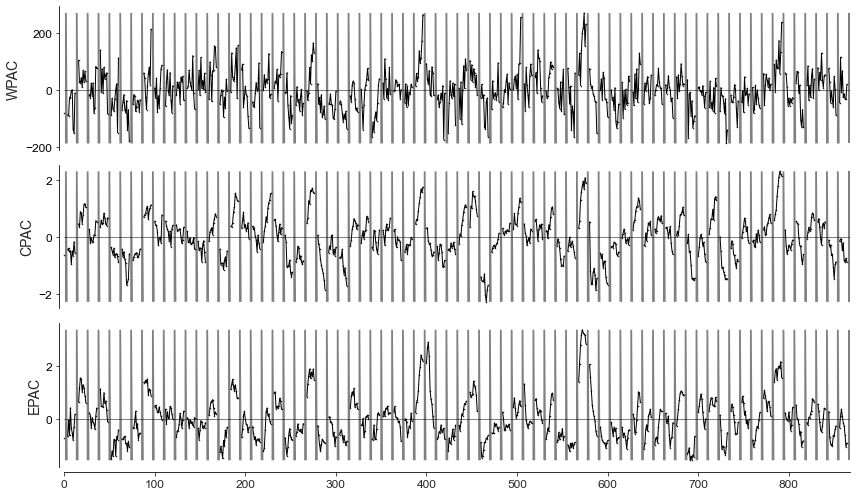

In [1142]:
dataframe = pp.DataFrame(np.copy(df_reanalysis_processed), datatime = {0:np.arange(len(df_reanalysis_processed))}, var_names= var_names, mask = springbarrier_mask)
tp.plot_timeseries(dataframe, figsize=(12,7), grey_masked_samples='fill', show_meanline=True, label_fontsize = 14, tick_label_size = 12)
#plt.savefig('/Users/hp/Documents/Econometrics; Climate Economics/Scriptie/Data' + 'springbarriermask.png')

           WPAC      CPAC      EPAC
0    -78.643744 -0.613275 -0.735567
1   -129.712829 -0.698227 -0.580214
2    -69.853579 -0.348744 -0.727400
3   -150.133303 -0.533868 -0.643373
4    -86.281518 -0.440536 -0.674719
..          ...       ...       ...
863  -30.756078 -0.739611 -1.066024
864   20.334989 -0.872991 -0.926480
865  -73.512033 -0.586084 -0.849890
866  -56.230826 -0.628241  0.058566
867  -81.288700 -0.598701 -0.568863

[868 rows x 3 columns]

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable WPAC has 4 link(s):
        (WPAC -2): max_pval = 0.00000, min_val =  0.251
        (CPAC -1): max_pval = 0.00000, min_val =  0.211
        (WPAC -1): max_pval = 0.00022, min_val =  0.145
        (EPAC -1): max_pval = 0.00036, min_val =  0.140

    Variable CPAC has 5 link(s):
        (CPAC -1): max_pval 

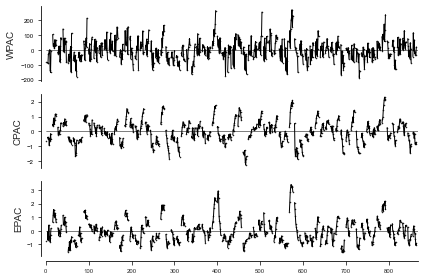

In [1143]:
print(df_reanalysis_processed)
dataframe = pp.DataFrame(np.copy(df_reanalysis_processed), datatime = {0:np.arange(len(df_reanalysis_processed))}, var_names= var_names, mask = springbarrier_mask)
tp.plot_timeseries(dataframe, color='black', show_meanline=True)
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=1)
results_springbarrier = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')
# fdr_method = 'fdr_bh'

In [1144]:
# contstruct spring barrier mask
cycle_length = 12
springbarrier_mask = np.ones(df_reanalysis_processed.shape, dtype=bool)
for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
    springbarrier_mask[i::cycle_length, :] = False
    
    
# Additionally mask to pick only La Nina phases in spring barrier
for t in range(springbarrier_mask.shape[0]):
    if ninamask_reanalysis[t] == True:
        springbarrier_mask[t] = True

count = 0

for i in range(springbarrier_mask.shape[0]):
    if springbarrier_mask[i][1] == False:
        count +=1

print(count/9)

32.0


(<Figure size 864x504 with 3 Axes>,
 array([<AxesSubplot:ylabel='WPAC'>, <AxesSubplot:ylabel='CPAC'>,
        <AxesSubplot:ylabel='EPAC'>], dtype=object))

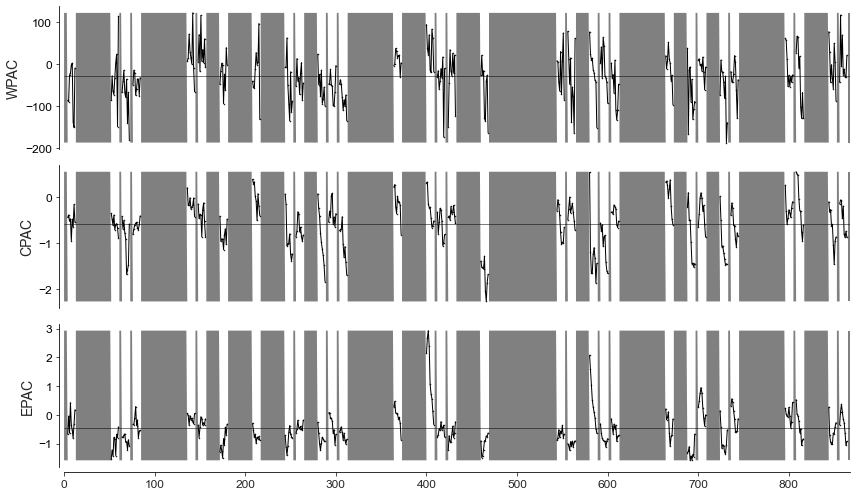

In [1145]:
dataframe = pp.DataFrame(np.copy(df_reanalysis_processed), datatime = {0:np.arange(len(df_reanalysis_processed))}, var_names= var_names, mask = springbarrier_mask)
tp.plot_timeseries(dataframe, figsize=(12,7), grey_masked_samples='fill', show_meanline=True, label_fontsize = 14, tick_label_size = 12)
#plt.savefig('/Users/hp/Documents/Econometrics; Climate Economics/Scriptie/Data' + 'ninamask.png')


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable WPAC has 3 link(s):
        (WPAC -2): max_pval = 0.00000, min_val =  0.272
        (EPAC -1): max_pval = 0.01016, min_val =  0.152
        (CPAC -2): max_pval = 0.02699, min_val =  0.131

    Variable CPAC has 3 link(s):
        (CPAC -1): max_pval = 0.00000, min_val =  0.666
        (WPAC -1): max_pval = 0.01773, min_val =  0.140
        (WPAC -3): max_pval = 0.04536, min_val =  0.118

    Variable EPAC has 2 link(s):
        (EPAC -1): max_pval = 0.00000, min_val =  0.659
        (EPAC -3): max_pval = 0.02595, min_val = -0.132

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 1
tau_max = 3
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.05:

    Variable WPAC has 1 link(s):
        (WPAC 

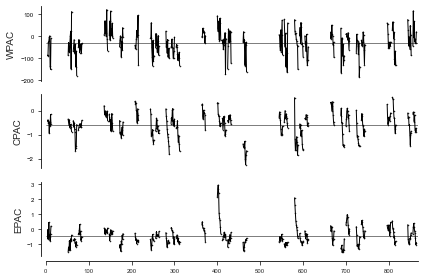

In [1146]:
dataframe = pp.DataFrame(np.copy(df_reanalysis_processed), datatime = {0:np.arange(len(df_reanalysis_processed))}, var_names= var_names, mask = springbarrier_mask)
tp.plot_timeseries(dataframe, color='black', show_meanline=True)
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=1)
results_nina = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

In [1147]:
# contstruct spring barrier mask
cycle_length = 12
springbarrier_mask = np.ones(df_reanalysis_processed.shape, dtype=bool)
for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
    springbarrier_mask[i::cycle_length, :] = False

# Additionally mask to pick only neutral and La Nina phases
for t in range(springbarrier_mask.shape[0]):
    if ninomask_reanalysis[t] == True:
        springbarrier_mask[t] = True

count = 0

for i in range(springbarrier_mask.shape[0]):
    if springbarrier_mask[i][1] == False:
        count +=1

print(count/9)

15.0


(<Figure size 864x504 with 3 Axes>,
 array([<AxesSubplot:ylabel='WPAC'>, <AxesSubplot:ylabel='CPAC'>,
        <AxesSubplot:ylabel='EPAC'>], dtype=object))

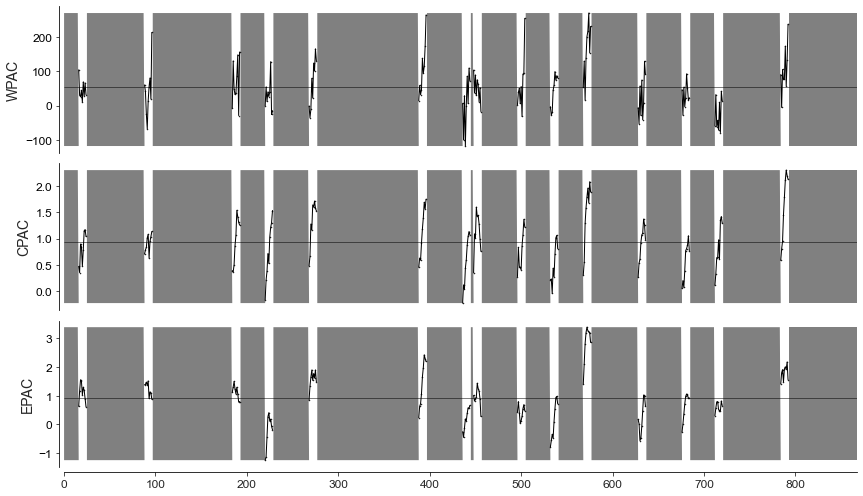

In [1148]:
dataframe = pp.DataFrame(np.copy(df_reanalysis_processed), datatime = {0:np.arange(len(df_reanalysis_processed))}, var_names= var_names, mask = springbarrier_mask)
tp.plot_timeseries(dataframe, figsize=(12,7), grey_masked_samples='fill', show_meanline=True, label_fontsize = 14, tick_label_size = 12)
#plt.savefig('/Users/hp/Documents/Econometrics; Climate Economics/Scriptie/Data' + 'ninomask.png')


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable WPAC has 3 link(s):
        (WPAC -2): max_pval = 0.00075, min_val =  0.290
        (CPAC -1): max_pval = 0.00184, min_val =  0.269
        (WPAC -1): max_pval = 0.03512, min_val =  0.184

    Variable CPAC has 3 link(s):
        (CPAC -1): max_pval = 0.00000, min_val =  0.557
        (CPAC -3): max_pval = 0.00058, min_val =  0.292
        (EPAC -1): max_pval = 0.00190, min_val =  0.268

    Variable EPAC has 3 link(s):
        (EPAC -1): max_pval = 0.00000, min_val =  0.817
        (CPAC -2): max_pval = 0.02478, min_val = -0.195
        (EPAC -2): max_pval = 0.03571, min_val = -0.182

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 1
tau_max = 3
max_conds_py = None
max_conds_px = None

## Significant links at alpha 

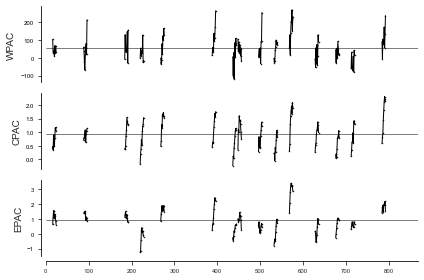

In [1149]:
dataframe = pp.DataFrame(np.copy(df_reanalysis_processed), datatime = {0:np.arange(len(df_reanalysis_processed))}, var_names= var_names, mask = springbarrier_mask)
tp.plot_timeseries(dataframe, color='black', show_meanline=True)
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=1)
results_nino = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

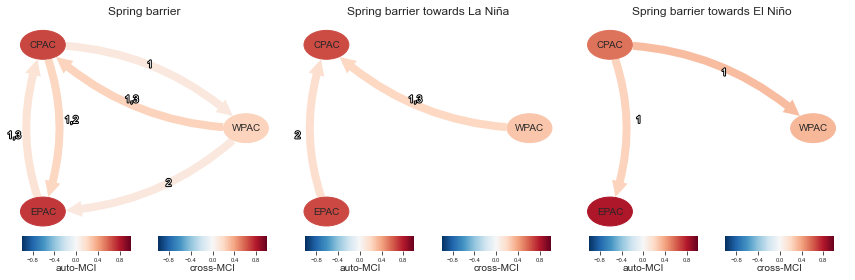

In [1150]:
## PLOT ALL DAGS

fig, axes = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

#tp.plot_graph(
#    val_matrix=results_nomask['val_matrix'],
#    graph=results_nomask['graph'],
#    var_names=var_names,
#    fig_ax= (fig, axes[0,0]))
#axes[0, 0].set_title('All observations')

tp.plot_graph(
    val_matrix=results_springbarrier['val_matrix'],
    graph=results_springbarrier['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    fig_ax= (fig, axes[0]))
axes[0].set_title('Spring barrier')

tp.plot_graph(
    val_matrix=results_nina['val_matrix'],
    graph=results_nina['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    fig_ax= (fig, axes[1]))
axes[1].set_title('Spring barrier towards La Niña')

tp.plot_graph(
    val_matrix=results_nino['val_matrix'],
    graph=results_nino['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    fig_ax= (fig, axes[2]))
axes[2].set_title('Spring barrier towards El Niño')

plt.subplots_adjust(hspace=0.8)
plt.show()

# NEW DATA: CESM2 model

In [889]:
# Pick time range
start_year = 1850
length = 12*(2023 - start_year)

CESM2_data = np.vstack((
    np.loadtxt('icmip6_psl_mon_CESM2_ssp585.0_130-150E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_CESM2_ssp585.0_-150--130E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
    np.loadtxt('icmip6_tas_mon_CESM2_ssp585.0_-100--80E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)[:length],
                )).T
T, N = CESM2_data.shape

In [890]:
# but skip first 100 years, so skip 12*100 = 1200 extra rows
CESM2_data = CESM2_data[1200:]

print(len(CESM2_data))

876


In [891]:
# Simple way to define time axis
datatime = np.linspace(start_year, 2023-1./12., T)

# Variable names used throughout
var_names = ['WPAC', 'CPAC', 'EPAC']

df_CESM2 = pd.DataFrame(CESM2_data, columns=var_names)

In [892]:
dataframe_CESM2 = pp.DataFrame(CESM2_data, 
                         datatime = np.arange(len(CESM2_data)), 
                         var_names=var_names)

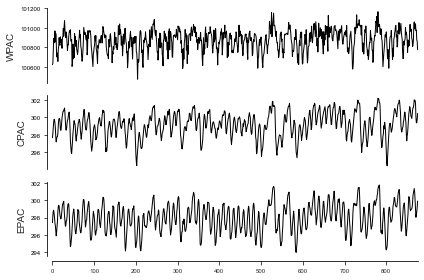

In [893]:
tp.plot_timeseries(dataframe_CESM2); plt.show()

In [894]:
cpac_detrend = deTrend_deSeasonalize(df_CESM2['CPAC'], show_plot = False)
epac_detrend = deTrend_deSeasonalize(df_CESM2['EPAC'], show_plot = False)
wpac_detrend = deTrend_deSeasonalize(df_CESM2['WPAC'], show_plot = False)

In [895]:
df_CESM2_processed = pd.DataFrame({'WPAC': wpac_detrend, 'CPAC': cpac_detrend, 'EPAC': epac_detrend})

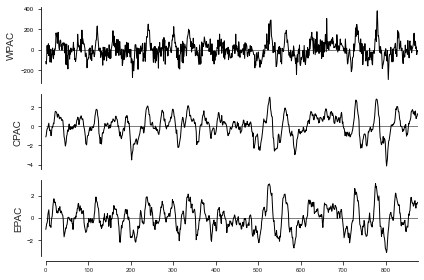

In [896]:
dataframe = pp.DataFrame(df_CESM2_processed.values, datatime = {0:np.arange(len(df_CESM2_processed))}, var_names= var_names)

tp.plot_timeseries(dataframe, color='black', show_meanline=True)
plt.show()

In [897]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


In [898]:
# Causal network 1: All observations
pcmci.verbosity = 1
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=1)
results_nomask = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable WPAC has 4 link(s):
        (WPAC -1): max_pval = 0.00000, min_val =  0.209
        (CPAC -2): max_pval = 0.00000, min_val =  0.178
        (WPAC -2): max_pval = 0.00103, min_val =  0.111
        (EPAC -2): max_pval = 0.01596, min_val =  0.082

    Variable CPAC has 7 link(s):
        (CPAC -1): max_pval = 0.00000, min_val =  0.722
        (EPAC -1): max_pval = 0.00000, min_val =  0.303
        (CPAC -3): max_pval = 0.00006, min_val = -0.136
        (WPAC -2): max_pval = 0.00165, min_val = -0.107
        (WPAC -3): max_pval = 0.00181, min_val = -0.106
        (WPAC -1): max_pval = 0.01177, min_val = -0.085
        (CPAC -2): max_pval = 0.01282, min_val = -0.084

    Variable EPAC has 4 link(s):
        (EPAC -1): max_pval = 0.00000, min_val =  0.787
  

In [899]:
parcorr = ParCorr(significance='analytic', mask_type='x')

In [900]:
# compute nino3.4 index for CESM2 model

# Pick time range
#start_year = 1950
#length = 12*(2023 - start_year)

#nino34cesm2 = np.loadtxt('icmip6_tas_mon_CESM2_ssp585.0_-170--120E_-5-5N_n.dat.txt', skiprows=56)[:, 1:].reshape(-1)

#nino34cesm2 = nino34cesm2[1200:2076,1:]

#nino34cesm2_detrend = deTrend_deSeasonalize(nino34cesm2, show_plot = False)

#plt.plot(nino34cesm2_detrend)

#nino34cesm2_smoothed = pp.smooth(nino34cesm2_detrend, smooth_width=3, kernel='heaviside',
#           mask=None, residuals=False)

#plt.plot(nino34cesm2_smoothed)

In [901]:
nino34cesm2 = np.loadtxt('icmip6_tas_mon_CESM2_ssp585.0_-170--120E_-5-5N_n.dat.txt', skiprows=56)[:, :]

nino34cesm2 = nino34cesm2[100:174,:]

nino34cesm2list = nino34cesm2[:,1:].reshape(-1)

nino34cesm2list = deTrend(nino34cesm2list)

nino34cesm2list = nino34cesm2list.reshape(-1,12)

# NINO MASK

for i in range(len(nino34cesm2list)-1):
    if (nino34cesm2list[i,10] + nino34cesm2list[i,11] + nino34cesm2list[i+1,0])/3 > 0.5:
        nino34cesm2list[i,:] = False
    else:
        nino34cesm2list[i,:] = True

nino34cesm2list = nino34cesm2list[:len(nino34cesm2list)-1,:]        
print(len(nino34cesm2list))

ninomask = nino34cesm2list.reshape(-1)

nino_count = 0
for i in range(len(nino34cesm2list)):
    if nino34cesm2list[i,0] == False:
        nino_count += 1

print(nino_count)
        

73
23


In [902]:
nino34cesm2 = np.loadtxt('icmip6_tas_mon_CESM2_ssp585.0_-170--120E_-5-5N_n.dat.txt', skiprows=56)[:, :]

nino34cesm2 = nino34cesm2[100:174,:]

ninomask, ninamask = mask_maker(nino34cesm2)


ValueError: too many values to unpack (expected 2)

In [903]:

nino34cesm2 = np.loadtxt('icmip6_tas_mon_CESM2_ssp585.0_-170--120E_-5-5N_n.dat.txt', skiprows=56)[:, :]

nino34cesm2 = nino34cesm2[100:174,:]

nino34cesm2list = nino34cesm2[:,1:].reshape(-1)

nino34cesm2list = deTrend_deSeasonalize(nino34cesm2list, show_plot = False)

nino34cesm2list = nino34cesm2list.reshape(-1,12)

# NINA MASK

for i in range(len(nino34cesm2list)-1):
    if (nino34cesm2list[i,10] + nino34cesm2list[i,11] + nino34cesm2list[i+1,0])/3 < -0.5:
        nino34cesm2list[i,:] = False
    else:
        nino34cesm2list[i,:] = True

nino34cesm2list = nino34cesm2list[:len(nino34cesm2list)-1,:]        
print(len(nino34cesm2list))

ninamask = nino34cesm2list.reshape(-1)

nina_count = 0
for i in range(len(nino34cesm2list)):
    if nino34cesm2list[i,0] == False:
        nina_count += 1

print(nina_count)


73
25


In [904]:
nino34cesm2 = np.loadtxt('icmip6_tas_mon_CESM2_ssp585.0_-170--120E_-5-5N_n.dat.txt', skiprows=56)[:, :]

nino34cesm2 = nino34cesm2[100:174,:]

nino34cesm2list = nino34cesm2[:,1:].reshape(-1)

nino34cesm2list = deTrend_deSeasonalize(nino34cesm2list, show_plot = False)

nino34cesm2list = nino34cesm2list.reshape(-1,12)

# NEUTRAL MASK

for i in range(len(nino34cesm2list)-1):
    if -0.5 < (nino34cesm2list[i,10] + nino34cesm2list[i,11] + nino34cesm2list[i+1,0])/3 < 0.5:
        nino34cesm2list[i,:] = False
    else:
        nino34cesm2list[i,:] = True

nino34cesm2list = nino34cesm2list[:len(nino34cesm2list)-1,:]        
print(len(nino34cesm2list))

neutralmask = nino34cesm2list.reshape(-1)

neutral_count = 0
for i in range(len(nino34cesm2list)):
    if nino34cesm2list[i,0] == False:
        neutral_count += 1

print(neutral_count)

73
19


In [905]:
# Construct mask for spring barrier
cycle_length = 12
springbarrier_mask = np.ones(df_CESM2_processed.shape, dtype=bool)
for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
    springbarrier_mask[i::cycle_length, :] = False

count = 0

for i in range(springbarrier_mask.shape[0]):
    if springbarrier_mask[i][1] == False:
        count +=1

print(count)

657


           WPAC      CPAC      EPAC
0   -116.253588 -1.121867 -1.027787
1   -141.211123 -0.956361 -0.773225
2    -78.687484 -0.541653 -0.527964
3     39.793021 -0.287755 -0.447484
4    -37.634193 -0.223657 -0.219105
..          ...       ...       ...
871    9.353197  0.821601  0.877052
872   26.248719  0.800222  1.287138
873  -48.402254  1.005444  1.195432
874   -8.843880  1.098786  1.307461
875  -19.616264  1.303565  1.402286

[876 rows x 3 columns]

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable WPAC has 5 link(s):
        (WPAC -1): max_pval = 0.00000, min_val =  0.235
        (WPAC -3): max_pval = 0.00113, min_val =  0.128
        (WPAC -2): max_pval = 0.00190, min_val =  0.121
        (CPAC -1): max_pval = 0.00748, min_val =  0.105
        (CPAC -3): max_pval = 0.04154, min_val =  0.080

    V

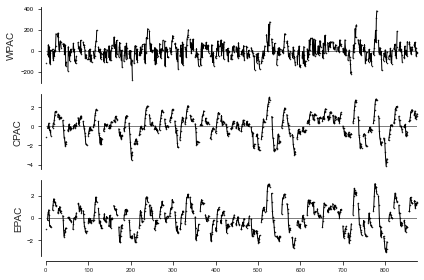

In [906]:
print(df_CESM2_processed)
dataframe = pp.DataFrame(np.copy(df_CESM2_processed), datatime = {0:np.arange(len(df_CESM2_processed))}, var_names= var_names, mask = springbarrier_mask)
tp.plot_timeseries(dataframe, color='black', show_meanline=True)
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=1)
results_springbarrier = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

In [907]:
# contstruct spring barrier mask
cycle_length = 12
springbarrier_mask = np.ones(df_CESM2_processed.shape, dtype=bool)
for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
    springbarrier_mask[i::cycle_length, :] = False
    
# Construct mask for spring barrier splitting to la nina
nina_mask = np.ones(length, dtype = 'bool')
for t in range(len(nino34cesm2_smoothed)):
    if np.sum(nino34cesm2_smoothed[max(0, t-3): min(length, t+2)] < -0.5) >= 5:
        nina_mask[t] = False
    
# Additionally mask to pick only La Nina phases in spring barrier
for t in range(springbarrier_mask.shape[0]):
    if ninamask[t] == True:
        springbarrier_mask[t] = True

count = 0

for i in range(springbarrier_mask.shape[0]):
    if springbarrier_mask[i][1] == False:
        count +=1

print(count)

225



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Variable WPAC

Iterating through pc_alpha = [0.05]:

# pc_alpha = 0.05 (1/1):

Testing condition sets of dimension 0:

    Link (WPAC -1) -?> WPAC (1/9):
    Subset 0: () gives pval = 0.00000 / val =  0.517
    No conditions of dimension 0 left.

    Link (WPAC -2) -?> WPAC (2/9):
    Subset 0: () gives pval = 0.00000 / val =  0.479
    No conditions of dimension 0 left.

    Link (WPAC -3) -?> WPAC (3/9):
    Subset 0: () gives pval = 0.00000 / val =  0.485
    No conditions of dimension 0 left.

    Link (CPAC -1) -?> WPAC (4/9):
    Subset 0: () gives pval = 0.00000 / val =  0.700
    No conditions of dimension 0 left.

    Link (CPAC -2) -?> WPAC (5/9):
    Subset 0: () gives pval = 0.00000 / val =  0.706
    No conditions of dimension 0 left.

    Link (CPAC -3) -?> WPAC (6/9):
    Subset 0: () gi

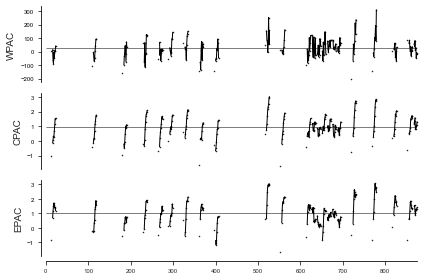

In [917]:
dataframe = pp.DataFrame(np.copy(df_CESM2_processed), datatime = {0:np.arange(len(df_CESM2_processed))}, var_names= var_names, mask = springbarrier_mask)
tp.plot_timeseries(dataframe, color='black', show_meanline=True)
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=20)
results_nina = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

In [909]:
# contstruct spring barrier mask
cycle_length = 12
springbarrier_mask = np.ones(df_CESM2_processed.shape, dtype=bool)
for i in [4, 5, 6, 7, 8, 9, 10, 11, 0]:
    springbarrier_mask[i::cycle_length, :] = False

# Construct mask for spring barrier splitting to el nino
nino_mask = np.ones(length, dtype = 'bool')
for t in range(length):
    if np.sum(nino34cesm2_smoothed[max(0, t-2): min(length, t+3)] > 0.5) >= 5:
        nino_mask[t] = False
    
# Additionally mask to pick only El Nino years 
for t in range(springbarrier_mask.shape[0]):
    if ninomask[t] == True:
        springbarrier_mask[t] = True

count = 0

for i in range(springbarrier_mask.shape[0]):
    if springbarrier_mask[i][1] == False:
        count +=1

print(count)

207



##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable WPAC has 3 link(s):
        (CPAC -2): max_pval = 0.00073, min_val =  0.235
        (WPAC -1): max_pval = 0.01854, min_val =  0.165
        (CPAC -1): max_pval = 0.02705, min_val =  0.155

    Variable CPAC has 4 link(s):
        (CPAC -1): max_pval = 0.00000, min_val =  0.780
        (EPAC -1): max_pval = 0.00009, min_val =  0.271
        (CPAC -3): max_pval = 0.00571, min_val = -0.194
        (EPAC -2): max_pval = 0.04493, min_val = -0.141

    Variable EPAC has 3 link(s):
        (EPAC -1): max_pval = 0.00000, min_val =  0.788
        (EPAC -2): max_pval = 0.01428, min_val = -0.172
        (CPAC -3): max_pval = 0.03022, min_val = -0.153

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 1
tau_max = 3
max_conds_py = 

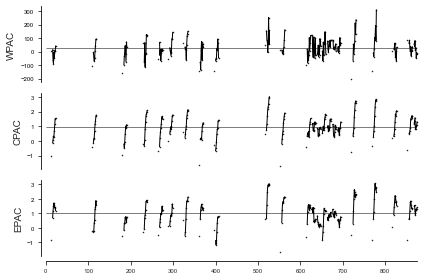

In [910]:
dataframe = pp.DataFrame(np.copy(df_CESM2_processed), datatime = {0:np.arange(len(df_CESM2_processed))}, var_names= var_names, mask = springbarrier_mask)
tp.plot_timeseries(dataframe, color='black', show_meanline=True)
pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr,verbosity=1)
results_nino = pcmci.run_pcmci(tau_max=3, tau_min=1, pc_alpha=0.05, alpha_level=0.05, fdr_method = 'fdr_bh')

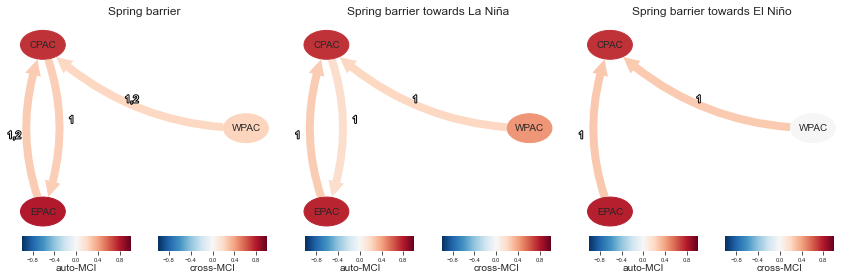

In [913]:
## PLOT ALL DAGS

fig, axes = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)

#tp.plot_graph(
#    val_matrix=results_nomask['val_matrix'],
#    graph=results_nomask['graph'],
#    var_names=var_names,
#    fig_ax= (fig, axes[0,0]))
#axes[0, 0].set_title('All observations')

tp.plot_graph(
    val_matrix=results_springbarrier['val_matrix'],
    graph=results_springbarrier['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    fig_ax= (fig, axes[0]))
axes[0].set_title('Spring barrier')

tp.plot_graph(
    val_matrix=results_nina['val_matrix'],
    graph=results_nina['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    fig_ax= (fig, axes[1]))
axes[1].set_title('Spring barrier towards La Niña')

tp.plot_graph(
    val_matrix=results_nino['val_matrix'],
    graph=results_nino['graph'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    fig_ax= (fig, axes[2]))
axes[2].set_title('Spring barrier towards El Niño')

plt.subplots_adjust(hspace=0.8)
plt.show()